In [1]:
import glob
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np

In [2]:
class DatasetSegmentation(Dataset):
    def __init__(self, folder_path, transform):
        super(DatasetSegmentation, self).__init__()
        self.img_files = glob.glob(os.path.join(folder_path, 'Images', '*.png'))
        self.mask_files = glob.glob(os.path.join(folder_path, 'Labels', '*.png'))
        self.transform = transform

    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]

        # data = Image.open(img_path).convert('RGB')  ## no se si es necesario que tenga 3 canales la imagen
        data = Image.open(img_path)
        # label = Image.open(mask_path).convert('RGB')
        label = Image.open(mask_path)

        data = self.transform(data)
        label = self.transform(label)

        return data, label

    def __len__(self):
        return len(self.img_files)



In [3]:
size_inp_img = 128

trans = transforms.Compose([
    transforms.Resize(size_inp_img, interpolation=1),  # para acotar el tiempo de entrenamiento
    transforms.ToTensor()
])

train_path = '/kaggle/input/jsrtdatabase/data/Train'
validation_path = '/kaggle/input/jsrtdatabase/data/Val'
test_path = '/kaggle/input/jsrtdatabase/data/Test'

train_set = DatasetSegmentation(train_path, trans)
val_set = DatasetSegmentation(validation_path, trans)
test_set = DatasetSegmentation(test_path, trans)

image_datasets = {'train': train_set, 'val': val_set, 'test': test_set}

batch_size = 2  # especificar tamaño del batch

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size),
    'val': DataLoader(val_set, batch_size=batch_size),
    'test': DataLoader(test_set, batch_size=batch_size)
}



/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:330: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


In [4]:
def one_hot_encoding(pt_tensor, fixed_labels=None):
    """
    Given a hard segmentation PyTorch tensor, it returns the 1-hot encoding.

    :param pt_tensor: Batch of Tensor or tuple of batch of tensors to be encoded.
    :param fixed_labels: Labels to encode (optional).
    :return: Encoded batch (or tuple) of tensors.
    """
    batch_size = pt_tensor.shape[0]
    hard_segm = pt_tensor.cpu().numpy()
    labels = np.unique(hard_segm) if fixed_labels is None else fixed_labels
    dims = hard_segm.shape

    uniq_labels = len(labels)

    one_hot = np.ndarray(shape=(batch_size, uniq_labels, dims[1], dims[2]), dtype=np.float32)

    # Transform the Hard Segmentation GT to one-hot encoding
    for j, labelValue in enumerate(labels):
        one_hot[:, j, :, :] = (hard_segm == labelValue).astype(np.int16)

    encoded = torch.from_numpy(one_hot)
    return encoded


def reverse_transform(inp):
    """ Esta función permite revertir las transformaciones aplicadas al inicio para poder mostrar cómo son originalmente """
    inp = transforms.ToPILImage()(inp)

    return inp


class BaseConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, stride):
        super(BaseConv, self).__init__()

        self.act = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding, stride)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding, stride)

    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        return x



In [5]:
class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, stride):
        super(DownConv, self).__init__()

        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv_block = BaseConv(in_channels, out_channels, kernel_size, padding, stride)

    def forward(self, x):
        x = self.pool1(x)
        x = self.conv_block(x)
        return x


class UpConv(nn.Module):
    def __init__(self, in_channels, in_channels_skip, out_channels, kernel_size, padding, stride):
        super(UpConv, self).__init__()

        # self.conv_trans1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, padding=0, stride=2) # original... converge mas lento
        self.conv_trans1 = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, padding=0, stride=2)
        # ConvTranspose is a convolution and has trainable kernels while Upsample is a simple interpolation (bilinear, nearest etc.)
        # https://medium.com/activating-robotic-minds/up-sampling-with-transposed-convolution-9ae4f2df52d0

        self.conv_block = BaseConv(
            in_channels=in_channels + in_channels_skip,
            # in_channels = out_channels,  # original... converge mas lento
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=padding,
            stride=stride)

    def forward(self, x, x_skip):
        x = self.conv_trans1(x)
        x = torch.cat((x, x_skip), dim=1)
        x = self.conv_block(x)
        return x


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, n_class, kernel_size, padding, stride):
        super(UNet, self).__init__()

        self.init_conv = BaseConv(in_channels, out_channels, kernel_size, padding, stride)  # 2 conv

        self.down1 = DownConv(out_channels, 2 * out_channels, kernel_size, padding, stride)  # max pool y 2 (conv+relu)
        self.down2 = DownConv(2 * out_channels, 4 * out_channels, kernel_size, padding,
                              stride)  # max pool y 2 (conv+relu)
        self.down3 = DownConv(4 * out_channels, 8 * out_channels, kernel_size, padding,
                              stride)  # max pool y 2 (conv+relu)
        # el original hace un DownConv más

        self.up3 = UpConv(8 * out_channels, 4 * out_channels, 4 * out_channels, kernel_size, padding,
                          stride)  # upconv, concat, 2 (conv+relu)
        self.up2 = UpConv(4 * out_channels, 2 * out_channels, 2 * out_channels, kernel_size, padding,
                          stride)  # upconv, concat, 2 (conv+relu)
        self.up1 = UpConv(2 * out_channels, out_channels, out_channels, kernel_size, padding,
                          stride)  # upconv, concat, 2 (conv+relu)

        self.out = nn.Conv2d(out_channels, n_class, kernel_size, padding, stride)

    def forward(self, x):
        # Encoder
        x = self.init_conv(x)
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        # Decoder
        x_up = self.up3(x3, x2)
        x_up = self.up2(x_up, x1)
        x_up = self.up1(x_up, x)
        x_out = F.log_softmax(self.out(x_up), dim=1)  # en otras arquitecturas unet no hace esto
        # x_out = F.softmax(self.out(x_up), dim=1)

        # softmax -> prob que suman 1 ... log_softmax -> reales negativos
        # identity activations in the final layer -> CrossEntropyLoss ... log_softmax activation -> NLLLoss
        # https://stats.stackexchange.com/questions/436766/cross-entropy-with-log-softmax-activation
        # https://discuss.pytorch.org/t/does-nllloss-handle-log-softmax-and-softmax-in-the-same-way/8835/6
        # https://medium.com/data-science-bootcamp/understand-the-softmax-function-in-minutes-f3a59641e86d 

        return x_out


In [6]:
nb_classes = 2  # se cuenta desde la clase 0 a la 9
model = UNet(in_channels=1,
             out_channels=64,
             n_class=nb_classes,
             kernel_size=3,
             padding=1,
             stride=1)
model = model.cuda()

loss_fn = nn.NLLLoss()
# loss_fn = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)

Epoch: [0/10]
  [2/87] Training loss: 0.202
  [4/87] Training loss: 0.332
  [6/87] Training loss: 0.265
  [8/87] Training loss: 0.178
  [10/87] Training loss: 0.268
  [12/87] Training loss: 0.203
  [14/87] Training loss: 0.265
  [16/87] Training loss: 0.283
  [18/87] Training loss: 0.268
  [20/87] Training loss: 0.292
  [22/87] Training loss: 0.213
  [24/87] Training loss: 0.330
  [26/87] Training loss: 0.239
  [28/87] Training loss: 0.190
  [30/87] Training loss: 0.171
  [32/87] Training loss: 0.284
  [34/87] Training loss: 0.235
  [36/87] Training loss: 0.215
  [38/87] Training loss: 0.386
  [40/87] Training loss: 0.243
  [42/87] Training loss: 0.220
  [44/87] Training loss: 0.220
  [46/87] Training loss: 0.229
  [48/87] Training loss: 0.206
  [50/87] Training loss: 0.184
  [2/11] Validation loss: 0.661
  [4/11] Validation loss: 0.722
  [6/11] Validation loss: 0.631
  [8/11] Validation loss: 0.617
  [10/11] Validation loss: 0.651
  [12/11] Validation loss: 0.504
  [14/11] Validation 

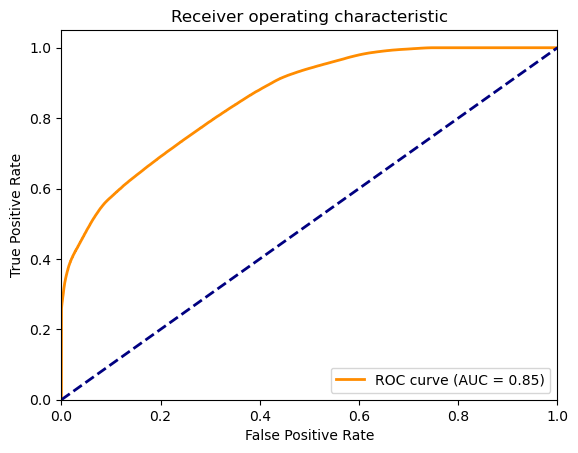

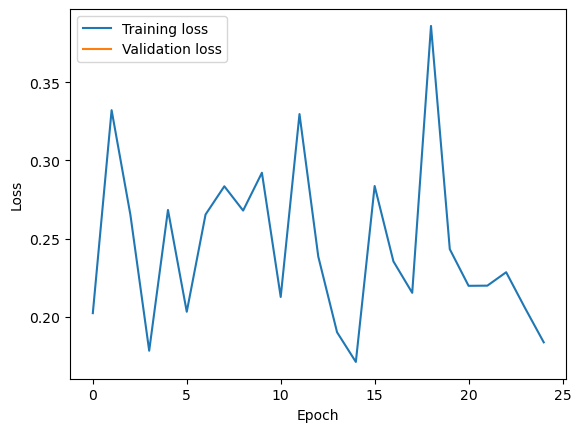

Epoch: [1/10]
  [2/87] Training loss: 0.191
  [4/87] Training loss: 0.349
  [6/87] Training loss: 0.281
  [8/87] Training loss: 0.180
  [10/87] Training loss: 0.264
  [12/87] Training loss: 0.220
  [14/87] Training loss: 0.265
  [16/87] Training loss: 0.286
  [18/87] Training loss: 0.263
  [20/87] Training loss: 0.278
  [22/87] Training loss: 0.206
  [24/87] Training loss: 0.337
  [26/87] Training loss: 0.233
  [28/87] Training loss: 0.188
  [30/87] Training loss: 0.173
  [32/87] Training loss: 0.267
  [34/87] Training loss: 0.227
  [36/87] Training loss: 0.214
  [38/87] Training loss: 0.380
  [40/87] Training loss: 0.254
  [42/87] Training loss: 0.226
  [44/87] Training loss: 0.212
  [46/87] Training loss: 0.230
  [48/87] Training loss: 0.197
  [50/87] Training loss: 0.186
  [2/11] Validation loss: 0.685
  [4/11] Validation loss: 0.749
  [6/11] Validation loss: 0.650
  [8/11] Validation loss: 0.644
  [10/11] Validation loss: 0.675
  [12/11] Validation loss: 0.512
  [14/11] Validation 

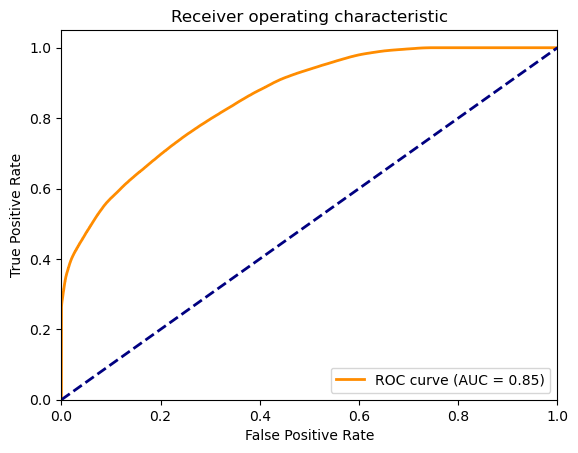

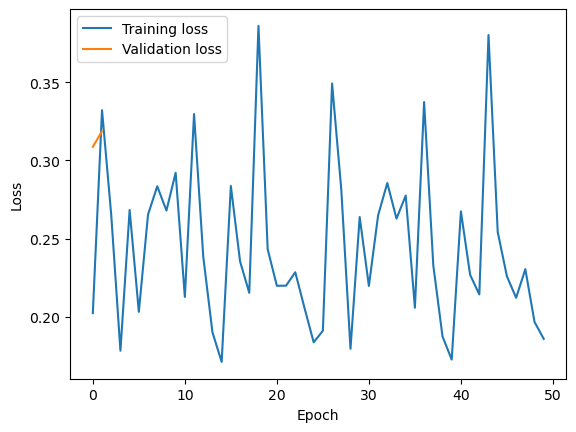

Epoch: [2/10]
  [2/87] Training loss: 0.184
  [4/87] Training loss: 0.350
  [6/87] Training loss: 0.276
  [8/87] Training loss: 0.175
  [10/87] Training loss: 0.270
  [12/87] Training loss: 0.203
  [14/87] Training loss: 0.262
  [16/87] Training loss: 0.296
  [18/87] Training loss: 0.264
  [20/87] Training loss: 0.286
  [22/87] Training loss: 0.210
  [24/87] Training loss: 0.338
  [26/87] Training loss: 0.218
  [28/87] Training loss: 0.193
  [30/87] Training loss: 0.175
  [32/87] Training loss: 0.277
  [34/87] Training loss: 0.221
  [36/87] Training loss: 0.207
  [38/87] Training loss: 0.369
  [40/87] Training loss: 0.251
  [42/87] Training loss: 0.237
  [44/87] Training loss: 0.212
  [46/87] Training loss: 0.230
  [48/87] Training loss: 0.199
  [50/87] Training loss: 0.197
  [2/11] Validation loss: 0.706
  [4/11] Validation loss: 0.754
  [6/11] Validation loss: 0.674
  [8/11] Validation loss: 0.656
  [10/11] Validation loss: 0.681
  [12/11] Validation loss: 0.547
  [14/11] Validation 

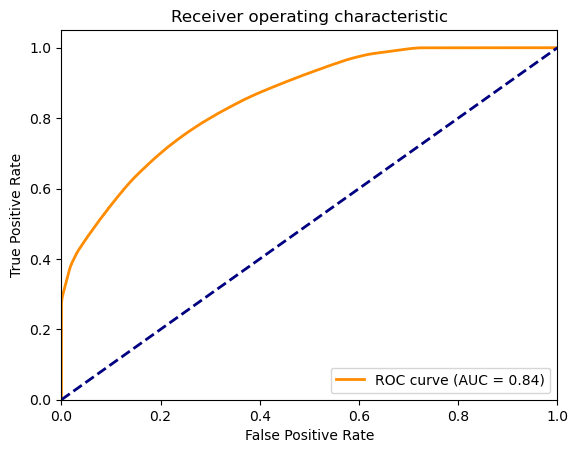

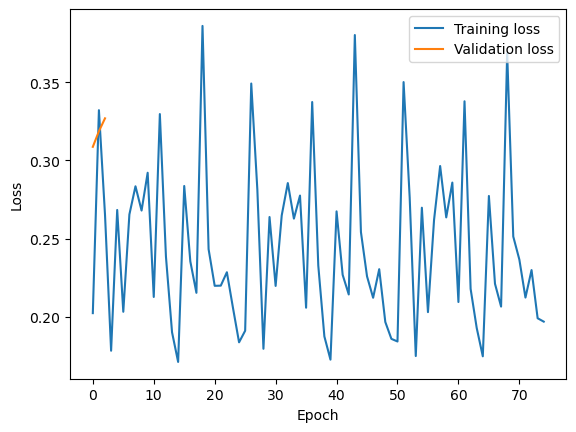

Epoch: [3/10]
  [2/87] Training loss: 0.193
  [4/87] Training loss: 0.353
  [6/87] Training loss: 0.264
  [8/87] Training loss: 0.171
  [10/87] Training loss: 0.271
  [12/87] Training loss: 0.191
  [14/87] Training loss: 0.257
  [16/87] Training loss: 0.273
  [18/87] Training loss: 0.260
  [20/87] Training loss: 0.285
  [22/87] Training loss: 0.211
  [24/87] Training loss: 0.315
  [26/87] Training loss: 0.227
  [28/87] Training loss: 0.189
  [30/87] Training loss: 0.174
  [32/87] Training loss: 0.300
  [34/87] Training loss: 0.218
  [36/87] Training loss: 0.200
  [38/87] Training loss: 0.371
  [40/87] Training loss: 0.237
  [42/87] Training loss: 0.225
  [44/87] Training loss: 0.223
  [46/87] Training loss: 0.237
  [48/87] Training loss: 0.194
  [50/87] Training loss: 0.194
  [2/11] Validation loss: 0.725
  [4/11] Validation loss: 0.779
  [6/11] Validation loss: 0.678
  [8/11] Validation loss: 0.678
  [10/11] Validation loss: 0.703
  [12/11] Validation loss: 0.562
  [14/11] Validation 

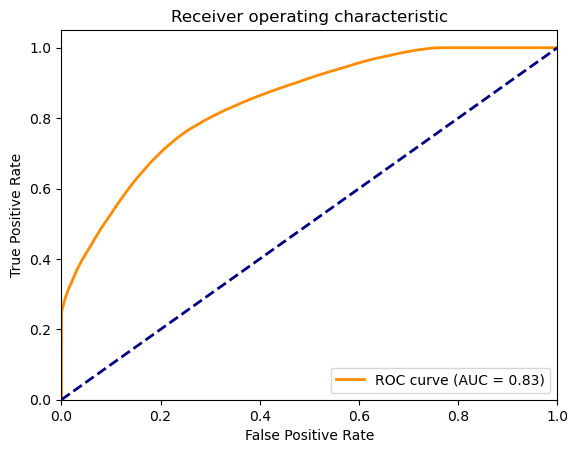

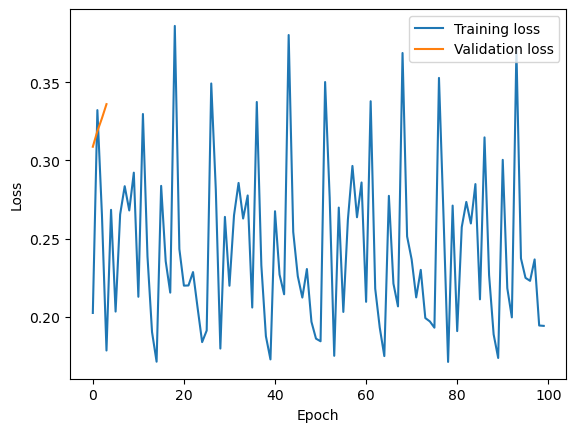

Epoch: [4/10]
  [2/87] Training loss: 0.193
  [4/87] Training loss: 0.336
  [6/87] Training loss: 0.254
  [8/87] Training loss: 0.176
  [10/87] Training loss: 0.276
  [12/87] Training loss: 0.191
  [14/87] Training loss: 0.257
  [16/87] Training loss: 0.264
  [18/87] Training loss: 0.257
  [20/87] Training loss: 0.298
  [22/87] Training loss: 0.217
  [24/87] Training loss: 0.306
  [26/87] Training loss: 0.236
  [28/87] Training loss: 0.188
  [30/87] Training loss: 0.171
  [32/87] Training loss: 0.284
  [34/87] Training loss: 0.218
  [36/87] Training loss: 0.206
  [38/87] Training loss: 0.371
  [40/87] Training loss: 0.217
  [42/87] Training loss: 0.215
  [44/87] Training loss: 0.227
  [46/87] Training loss: 0.231
  [48/87] Training loss: 0.200
  [50/87] Training loss: 0.191
  [2/11] Validation loss: 0.742
  [4/11] Validation loss: 0.820
  [6/11] Validation loss: 0.704
  [8/11] Validation loss: 0.690
  [10/11] Validation loss: 0.738
  [12/11] Validation loss: 0.560
  [14/11] Validation 

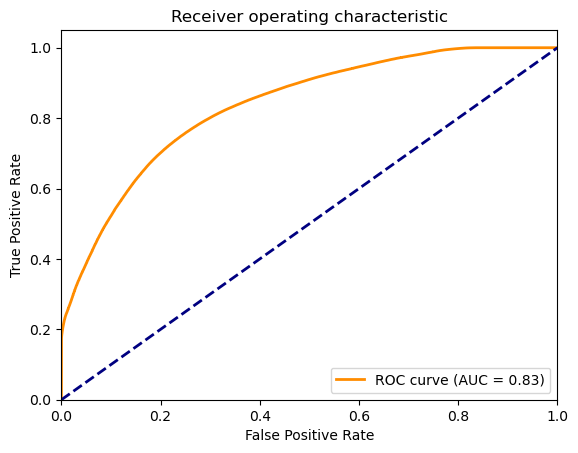

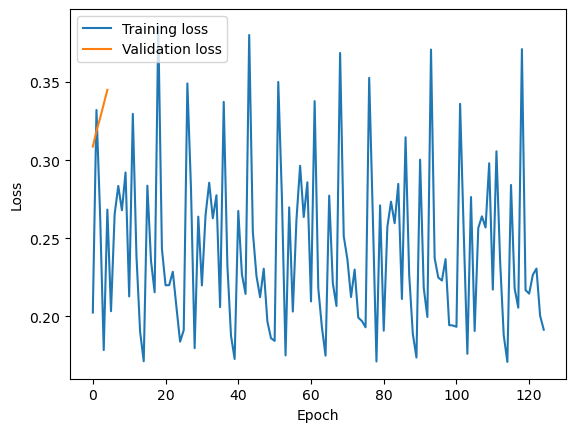

Epoch: [5/10]
  [2/87] Training loss: 0.195
  [4/87] Training loss: 0.318
  [6/87] Training loss: 0.254
  [8/87] Training loss: 0.179
  [10/87] Training loss: 0.264
  [12/87] Training loss: 0.189
  [14/87] Training loss: 0.256
  [16/87] Training loss: 0.261
  [18/87] Training loss: 0.250
  [20/87] Training loss: 0.296
  [22/87] Training loss: 0.215
  [24/87] Training loss: 0.296
  [26/87] Training loss: 0.238
  [28/87] Training loss: 0.189
  [30/87] Training loss: 0.163
  [32/87] Training loss: 0.277
  [34/87] Training loss: 0.230
  [36/87] Training loss: 0.211
  [38/87] Training loss: 0.376
  [40/87] Training loss: 0.205
  [42/87] Training loss: 0.211
  [44/87] Training loss: 0.216
  [46/87] Training loss: 0.231
  [48/87] Training loss: 0.205
  [50/87] Training loss: 0.188
  [2/11] Validation loss: 0.681
  [4/11] Validation loss: 0.749
  [6/11] Validation loss: 0.657
  [8/11] Validation loss: 0.633
  [10/11] Validation loss: 0.665
  [12/11] Validation loss: 0.501
  [14/11] Validation 

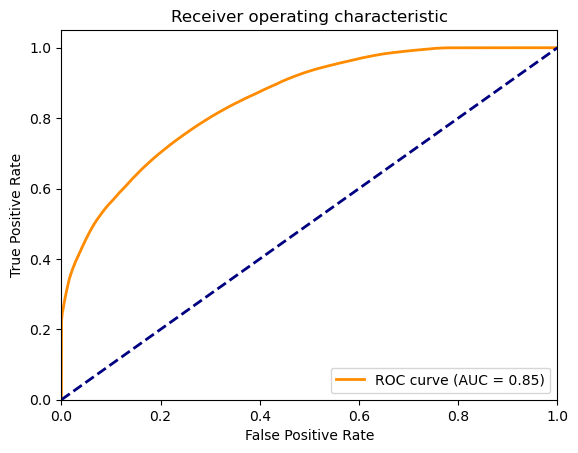

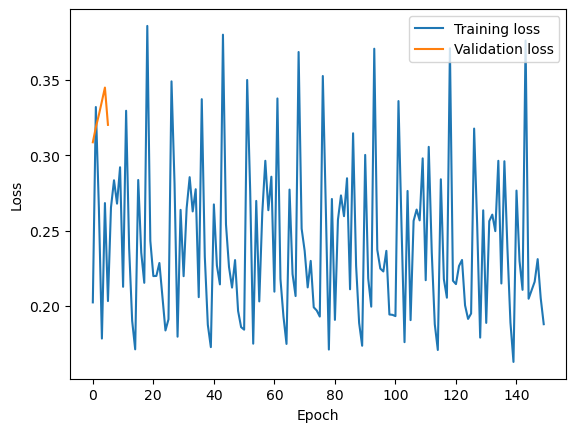

Epoch: [6/10]
  [2/87] Training loss: 0.191
  [4/87] Training loss: 0.328
  [6/87] Training loss: 0.267
  [8/87] Training loss: 0.176
  [10/87] Training loss: 0.261
  [12/87] Training loss: 0.203
  [14/87] Training loss: 0.265
  [16/87] Training loss: 0.277
  [18/87] Training loss: 0.257
  [20/87] Training loss: 0.270
  [22/87] Training loss: 0.203
  [24/87] Training loss: 0.321
  [26/87] Training loss: 0.236
  [28/87] Training loss: 0.184
  [30/87] Training loss: 0.170
  [32/87] Training loss: 0.265
  [34/87] Training loss: 0.220
  [36/87] Training loss: 0.217
  [38/87] Training loss: 0.372
  [40/87] Training loss: 0.240
  [42/87] Training loss: 0.214
  [44/87] Training loss: 0.214
  [46/87] Training loss: 0.218
  [48/87] Training loss: 0.185
  [50/87] Training loss: 0.174
  [2/11] Validation loss: 0.690
  [4/11] Validation loss: 0.742
  [6/11] Validation loss: 0.659
  [8/11] Validation loss: 0.639
  [10/11] Validation loss: 0.662
  [12/11] Validation loss: 0.515
  [14/11] Validation 

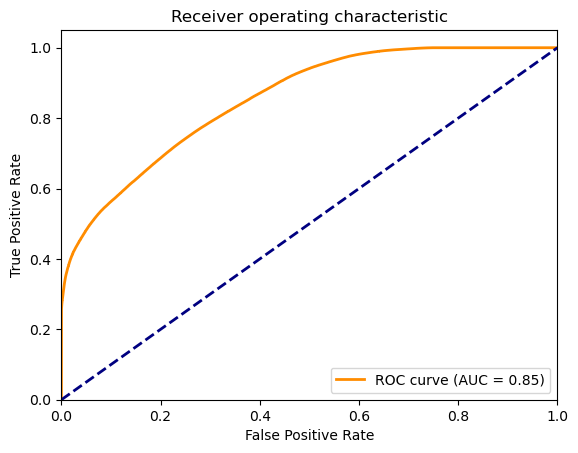

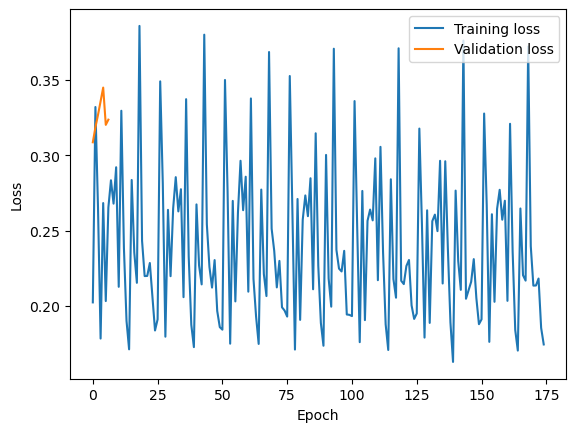

Epoch: [7/10]
  [2/87] Training loss: 0.180
  [4/87] Training loss: 0.347
  [6/87] Training loss: 0.273
  [8/87] Training loss: 0.176
  [10/87] Training loss: 0.263
  [12/87] Training loss: 0.201
  [14/87] Training loss: 0.263
  [16/87] Training loss: 0.282
  [18/87] Training loss: 0.256
  [20/87] Training loss: 0.271
  [22/87] Training loss: 0.202
  [24/87] Training loss: 0.322
  [26/87] Training loss: 0.222
  [28/87] Training loss: 0.184
  [30/87] Training loss: 0.174
  [32/87] Training loss: 0.254
  [34/87] Training loss: 0.209
  [36/87] Training loss: 0.208
  [38/87] Training loss: 0.357
  [40/87] Training loss: 0.219
  [42/87] Training loss: 0.220
  [44/87] Training loss: 0.214
  [46/87] Training loss: 0.232
  [48/87] Training loss: 0.186
  [50/87] Training loss: 0.189
  [2/11] Validation loss: 0.780
  [4/11] Validation loss: 0.846
  [6/11] Validation loss: 0.745
  [8/11] Validation loss: 0.717
  [10/11] Validation loss: 0.762
  [12/11] Validation loss: 0.585
  [14/11] Validation 

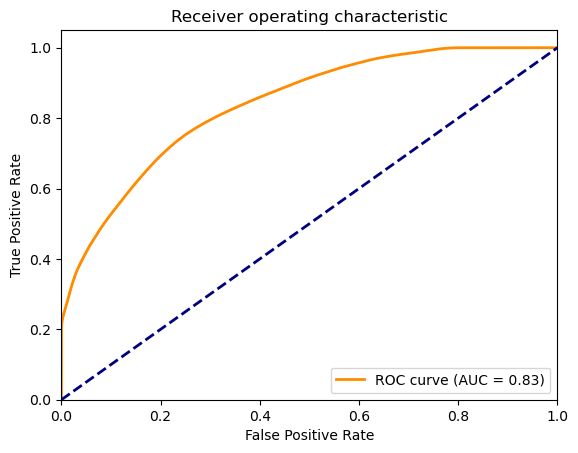

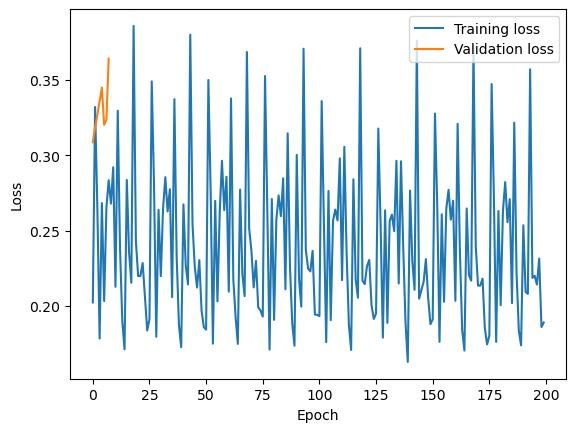

Epoch: [8/10]
  [2/87] Training loss: 0.184
  [4/87] Training loss: 0.320
  [6/87] Training loss: 0.253
  [8/87] Training loss: 0.176
  [10/87] Training loss: 0.262
  [12/87] Training loss: 0.189
  [14/87] Training loss: 0.250
  [16/87] Training loss: 0.273
  [18/87] Training loss: 0.251
  [20/87] Training loss: 0.292
  [22/87] Training loss: 0.206
  [24/87] Training loss: 0.328
  [26/87] Training loss: 0.214
  [28/87] Training loss: 0.193
  [30/87] Training loss: 0.172
  [32/87] Training loss: 0.274
  [34/87] Training loss: 0.207
  [36/87] Training loss: 0.199
  [38/87] Training loss: 0.365
  [40/87] Training loss: 0.215
  [42/87] Training loss: 0.215
  [44/87] Training loss: 0.212
  [46/87] Training loss: 0.220
  [48/87] Training loss: 0.182
  [50/87] Training loss: 0.194
  [2/11] Validation loss: 0.740
  [4/11] Validation loss: 0.793
  [6/11] Validation loss: 0.698
  [8/11] Validation loss: 0.672
  [10/11] Validation loss: 0.702
  [12/11] Validation loss: 0.556
  [14/11] Validation 

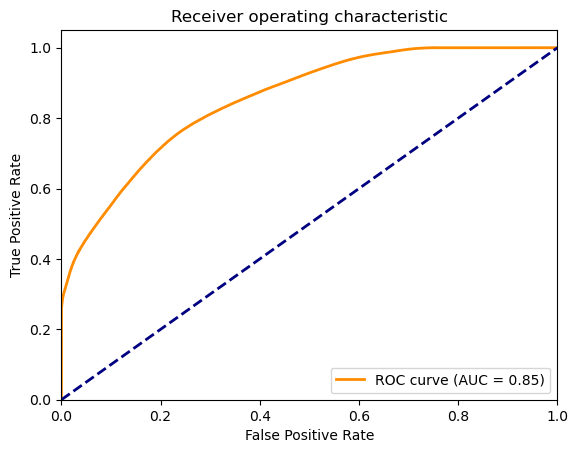

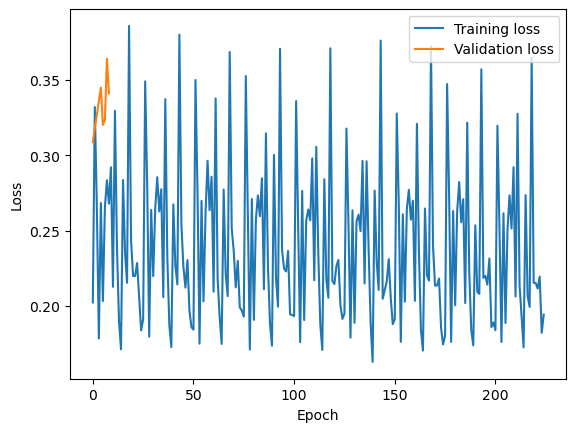

Epoch: [9/10]
  [2/87] Training loss: 0.179
  [4/87] Training loss: 0.351
  [6/87] Training loss: 0.259
  [8/87] Training loss: 0.171
  [10/87] Training loss: 0.281
  [12/87] Training loss: 0.189
  [14/87] Training loss: 0.253
  [16/87] Training loss: 0.255
  [18/87] Training loss: 0.247
  [20/87] Training loss: 0.277
  [22/87] Training loss: 0.210
  [24/87] Training loss: 0.295
  [26/87] Training loss: 0.214
  [28/87] Training loss: 0.184
  [30/87] Training loss: 0.165
  [32/87] Training loss: 0.279
  [34/87] Training loss: 0.219
  [36/87] Training loss: 0.198
  [38/87] Training loss: 0.365
  [40/87] Training loss: 0.207
  [42/87] Training loss: 0.213
  [44/87] Training loss: 0.218
  [46/87] Training loss: 0.232
  [48/87] Training loss: 0.189
  [50/87] Training loss: 0.189
  [2/11] Validation loss: 0.734
  [4/11] Validation loss: 0.802
  [6/11] Validation loss: 0.706
  [8/11] Validation loss: 0.689
  [10/11] Validation loss: 0.718
  [12/11] Validation loss: 0.551
  [14/11] Validation 

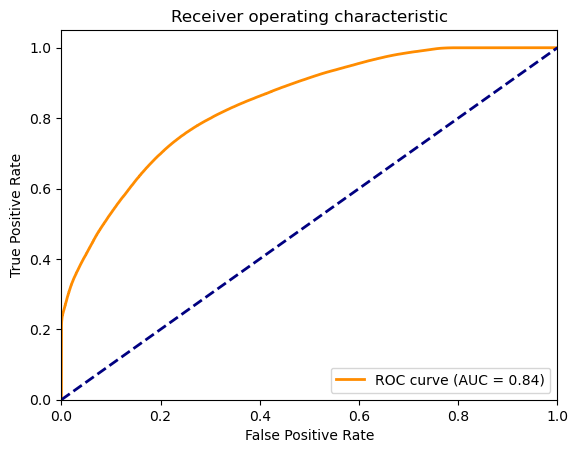

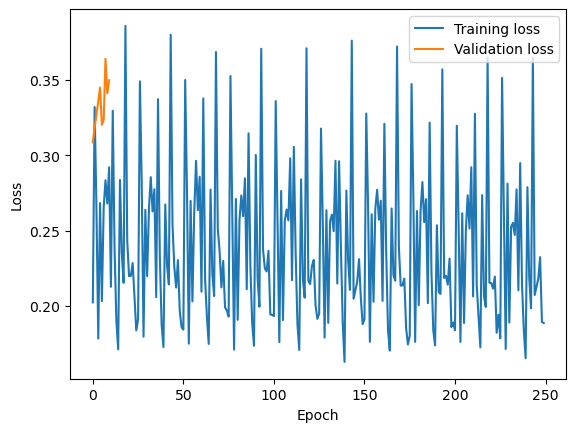

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    train_loss_list = []
    val_loss_list = []

    for epoch in range(epochs):
        

        training_loss, valid_loss, epoch_samples = 0.0, 0.0, 0

        model.train()  # activa dropout (en este caso no hay)
        print("Epoch: [{}/{}]".format(epoch, epochs))
        for inputs, target in train_loader:
            inputs = inputs.to(device)
            target = target / target.max()
            target = target.squeeze(1).type(torch.LongTensor).to(device)

            output = model(inputs)
            loss = loss_fn(output, target)

            optimizer.zero_grad()  # zeroes the grad attribute of all the parameters passed to the optimizer construction.
            loss.backward()  # calcula los gradientes respecto de los parametros
            optimizer.step()  # pasada hacia adelante actualizando los parametros
            if epoch_samples == 50:
                break
            # statistics
            training_loss += loss.data.item()  # extracts the loss’s value as a Python float
            epoch_samples += inputs.size(0)  # batch size
            

            print('  [{}/{}] Training loss: {:.3f}' .format(epoch_samples, len(train_loader), loss.data.item()))
            train_loss_list.append(loss.data.item())

        epoch_samples = 0

        model.eval()  # dropout is bypassed or, equivalently, assigned a probability  equal  to  zero.
        num_correct = 0
        num_examples = 0
        for inputs, target in val_loader:
            inputs = inputs.to(device)
            target = target.squeeze(1).type(torch.LongTensor).to(device)

            output = model(inputs)
            loss = loss_fn(output, target)

            # statistics
            valid_loss += loss.data.item()
            epoch_samples += inputs.size(0)  # batch size
            print('  [{}/{}] Validation loss: {:.3f}'.format(epoch_samples, len(val_loader), loss.data.item()))

        valid_loss /= epoch_samples
        
        val_loss_list.append(valid_loss)


        # Create empty lists to store the loss and accuracy for each epoch
        epoch_loss = []
        val_loss = []
        auc_list = []

        # Set the model to evaluation mode
        model.eval()

        # Create empty lists to store the ground truth and predictions for all batches
        y_true = []
        y_pred = []

        # Iterate over the validation data
        for inputs, targets in val_loader:

            # Move the inputs and targets to the device (GPU or CPU)
            inputs = inputs.to(device)
            targets = targets.squeeze(1).to(device)  # squeeze target tensor along second dimension

            # Forward pass through the model
            outputs = model(inputs)
            targets = targets.long()

            # Calculate the loss
            loss = loss_fn(outputs, targets)

            # Calculate the AUC
            outputs = F.softmax(outputs, dim=1)
            targets_one_hot = F.one_hot(targets, num_classes=outputs.shape[1])
            targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).to(device)
            y_true.extend(targets_one_hot.reshape(-1).cpu().numpy())

            y_pred.extend(outputs.view(-1).detach().cpu().numpy())
            fpr, tpr, _ = roc_curve(y_true, y_pred)
            auc_score = auc(fpr, tpr)
            auc_list.append(auc_score)

            # Add the loss to the validation loss for the epoch
            val_loss.append(loss.item())

        # Calculate the average validation loss for the epoch
        val_loss = sum(val_loss) / len(val_loss)

        # Calculate the average AUC for the epoch
        auc_epoch = sum(auc_list) / len(auc_list)

        # Add the validation loss and AUC to the epoch loss list
        

        # Plot the ROC curve
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_epoch)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
    
        plt.plot(train_loss_list, label='Training loss')
        plt.plot(val_loss_list, label='Validation loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()





        
           

train(model, optimizer, loss_fn, dataloaders['train'], dataloaders['val'], epochs=10)



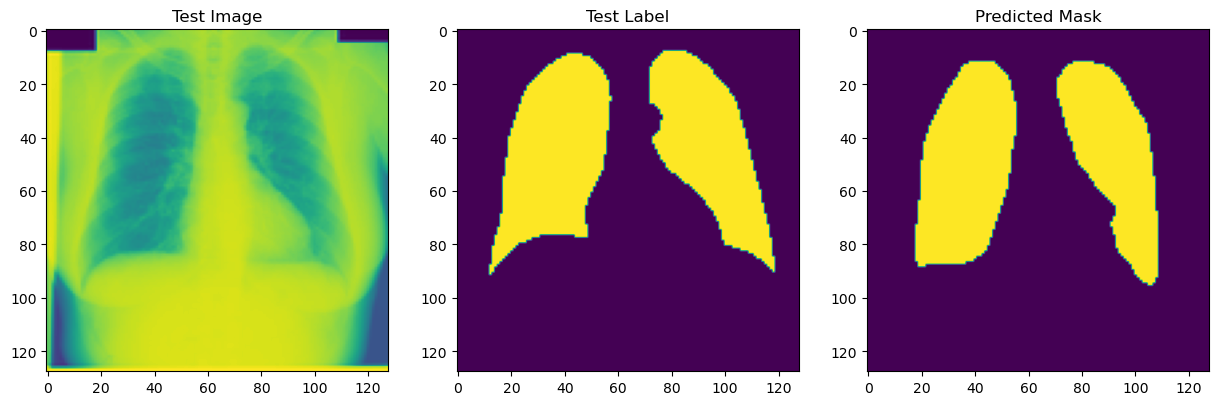

In [41]:
import matplotlib.pyplot as plt

# get a test image from the test dataset

test_image, test_label = next(iter(dataloaders['test']))

test_image = test_image.to(device)

# get the predicted mask from the trained model
with torch.no_grad():
    output = model(test_image)
    output = F.softmax(output, dim=1)
    pred = torch.argmax(output, dim=1)
    pred = one_hot_encoding(pred)

# plot the test image, label, and predicted mask
test_image = reverse_transform(test_image[0])
test_label = reverse_transform(test_label[0])
pred_mask = reverse_transform(pred[0][1])

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(test_image)
ax[0].set_title('Test Image')
ax[1].imshow(test_label)
ax[1].set_title('Test Label')
ax[2].imshow(pred_mask)
ax[2].set_title('Predicted Mask')
plt.show()


In [37]:
test_image_path = '/kaggle/input/jsrtdatabase/data/Test/Images/JPCLN010.png'
test_label_path = '/kaggle/input/jsrtdatabase/data/Test/Labels/JPCLN010_labels.png'

test_image = Image.open(test_image_path)
test_label = Image.open(test_label_path)

test_image_tensor = trans(test_image)
test_label_tensor = trans(test_label)

# Add an extra dimension to match the expected input shape of the model
test_image_tensor = test_image_tensor.unsqueeze(0)
test_label_tensor = test_label_tensor.unsqueeze(0)

# Move the tensors to the device (CPU or GPU) being used for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_image_tensor = test_image_tensor.to(device)
test_label_tensor = test_label_tensor.to(device)

# Use the model to generate a mask for the test image
test_output_tensor = model(test_image_tensor)

# Convert the output tensor to a one-hot encoding and extract the segmentation mask
test_output_tensor = one_hot_encoding(test_output_tensor)
test_mask_tensor = test_output_tensor[:, 1, :, :] # Assuming that the positive class is encoded as "1" and the negative class as "0"

# Convert the tensors back to PIL images
test_image = reverse_transform(test_image_tensor.squeeze(0).cpu())
test_label = reverse_transform(test_label_tensor.squeeze(0).cpu())
test_mask = reverse_transform(test_mask_tensor.squeeze(0).cpu())

# Display the images and mask
test_image.show()
test_label.show()
test_mask.show()


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.